#  Machine learning using RMS Titanic 

get data from  http://www.kaggle.com/c/titanic-gettingStarted/data. Download train and test set.

1) load all required packages and set plot option 

In [57]:
suppressPackageStartupMessages(require('dplyr'))
suppressPackageStartupMessages(require('ggplot2'))
suppressPackageStartupMessages(require('caret'))

##set plot option
options(repr.plot.width=6, repr.plot.height=3)


2) set directory to folder with downloaded file

In [58]:
setwd("M:/")
filepath=getwd()
setwd(paste(filepath, "R_Script/Input", sep="/"))

3)  read the train file

In [59]:
train = read.csv("train.csv", na.strings=c("NA", "")) 

4) let check structure of data

In [60]:
str(train)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 147 levels "A10","A14","A16",..: NA 82 NA 56 NA NA 130 NA NA NA ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


5) lets see  first 10 rows

In [61]:
head(train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,NA,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,NA,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,NA,S
6,6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


6) let convert sex, survive and pclass into numerical factor

In [62]:
train$Sex = factor(train$Sex)
train$Survived = factor(train$Survived)
train$Pclass = factor(train$Pclass)

7) If NA is present in any row than MLA will ignore these rows while building model,  which is not good as,  we want max no of data point. lets see summary to find NA

In [63]:
summary(train)

  PassengerId    Survived Pclass                                     Name    
 Min.   :  1.0   0:549    1:216   Abbing, Mr. Anthony                  :  1  
 1st Qu.:223.5   1:342    2:184   Abbott, Mr. Rossmore Edward          :  1  
 Median :446.0            3:491   Abbott, Mrs. Stanton (Rosa Hunt)     :  1  
 Mean   :446.0                    Abelson, Mr. Samuel                  :  1  
 3rd Qu.:668.5                    Abelson, Mrs. Samuel (Hannah Wizosky):  1  
 Max.   :891.0                    Adahl, Mr. Mauritz Nils Martin       :  1  
                                  (Other)                              :885  
     Sex           Age            SibSp           Parch             Ticket   
 female:314   Min.   : 0.42   Min.   :0.000   Min.   :0.0000   1601    :  7  
 male  :577   1st Qu.:20.12   1st Qu.:0.000   1st Qu.:0.0000   347082  :  7  
              Median :28.00   Median :0.000   Median :0.0000   CA. 2343:  7  
              Mean   :29.70   Mean   :0.523   Mean   :0.3816   3

8.a) We can see there are NA in Age, cabin and embarked. lets remove NA from Embarked. As there was only 3 NA value, 
let assign NA to most frequent embarked.

In [64]:
train$Embarked[which(is.na(train$Embarked))] ='S'
table(train$Embarked, useNA = "always")
train$Pclass = factor(train$Pclass)


   C    Q    S <NA> 
 168   77  646    0 

8.b) As ages have 177 missing value, lets fill in value. As we see name have intial like Mr., Mrs., Master,
We can use this info to add to add ages, we will find mean ages os each intial and assign these value to NA.

In [65]:
train$Name = as.character(train$Name)
table_names = table(unlist(strsplit(train$Name, "\\s+")))
sort(table_names[grep('\\.', names(table_names))], decreasing = T)

Mr.     Miss.      Mrs.   Master.       Dr.      Rev.      Col.    Major. 
      517       182       125        40         7         6         2         2 
    Mlle.     Capt. Countess.      Don. Jonkheer.        L.     Lady.      Mme. 
        2         1         1         1         1         1         1         1 
      Ms.      Sir. 
        1         1

   lets gets mean age for each intial, assign it to missing value

In [66]:
table_na = train[which(is.na(train$Age)),]
table_names = table(unlist(strsplit(table_na$Name, "\\s+")))
sort(table_names[grep('\\.', names(table_names))], decreasing = T)


title = c("Mr\\.", "Miss\\.", "Mrs\\.", "Master\\." ,"Dr\\.")

#means
sapply(title, function(x){
       mean(train$Age[grepl(x, train$Name) & !is.na(train$Age)])
})

# assign NA  value to means
for (x in title){
    train$Age[grepl(x, train$Name) & is.na(train$Age)]=mean(train$Age[grepl(x, train$Name) & !is.na(train$Age)])
}
summary(train$Age)

Mr.   Miss.    Mrs. Master.     Dr. 
    119      36      17       4       1

Mr\\.   Miss\\.    Mrs\\. Master\\.     Dr\\. 
32.368090 21.773973 35.898148  4.574167 42.000000

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.42   21.77   30.00   29.75   35.90   80.00 

9) let make some plot
a) **Sex vs survived**

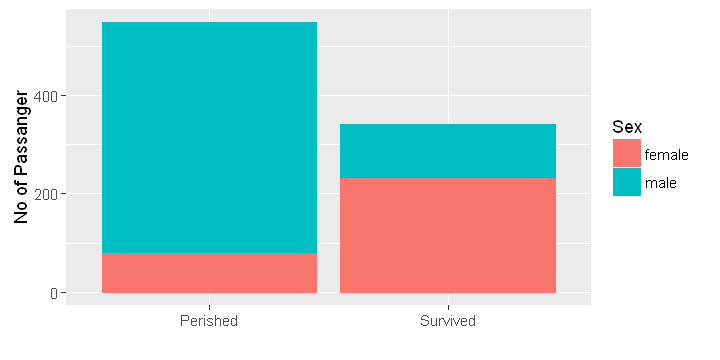

In [67]:
(ggplot(train, aes(Survived, fill=Sex)) 
     + geom_bar(aes(color = Sex) ) 
     + xlab("") 
     + ylab("No of Passanger") 
     +  scale_x_discrete(breaks=c("0", "1"),labels=c("Perished","Survived")))


b) **Ages Vs Survived**

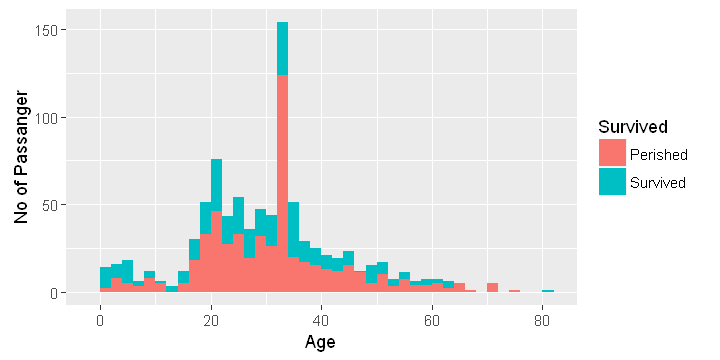

In [68]:
(ggplot(train, aes(Age, fill=Survived)) 
     + geom_histogram( binwidth = 2 ) 
     + xlab("Age") 
     + ylab("No of Passanger")
     + scale_fill_discrete(breaks=c("0", "1"),labels=c("Perished","Survived")))
     

c) **Class Vs Survived **

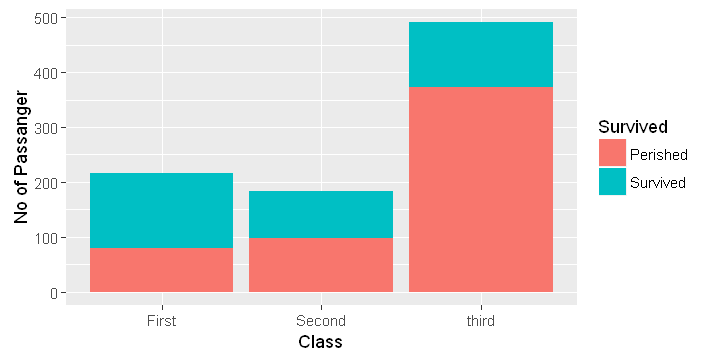

In [69]:
(ggplot(train, aes(Pclass, fill=Survived)) 
     + geom_bar( ) 
     + xlab("Class") 
     + ylab("No of Passanger") 
     +  scale_x_discrete(breaks=c("1", "2", "3"),labels=c("First","Second", "third"))
     +scale_fill_discrete(breaks=c("0", "1"),labels=c("Perished","Survived")))

10) lets covert evrything to numeric value

In [70]:
train$Sex = as.numeric(train$Sex)
train$Embarked = as.numeric(train$Embarked)
train$Pclass= as.numeric(train$Pclass)

11) lets splite data to training and testing, I will be using 'createDataPartition' from carat packages

In [71]:
intrain<-createDataPartition(y=train$Survive,p=0.7,list=FALSE)
traingset = train[intrain,]
testset = train[-intrain,]

12) let builtLogistics Regression Model 

In [72]:
reg = glm(Survived~Age+Pclass+Sex+SibSp+Embarked, data = traingset, family=binomial)
pred = predict(reg, testset, type='response')
class = ifelse(pred > .5,1,0)
tb = table(testset$Survive,class)

13) Lets see performance using confusion matrix

In [73]:
confusionMatrix(tb)

Confusion Matrix and Statistics

   class
      0   1
  0 138  26
  1  33  69
                                          
               Accuracy : 0.7782          
                 95% CI : (0.7234, 0.8267)
    No Information Rate : 0.6429          
    P-Value [Acc > NIR] : 1.259e-06       
                                          
                  Kappa : 0.5247          
 Mcnemar's Test P-Value : 0.4347          
                                          
            Sensitivity : 0.8070          
            Specificity : 0.7263          
         Pos Pred Value : 0.8415          
         Neg Pred Value : 0.6765          
             Prevalence : 0.6429          
         Detection Rate : 0.5188          
   Detection Prevalence : 0.6165          
      Balanced Accuracy : 0.7667          
                                          
       'Positive' Class : 0               
                                          

                                                     **Happy Coding**